## Author: Eoghan O'Connor

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv". 

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small.An autoencoder is used to detect anomalies in the data. The correctness of the model can of course be checked.

## Problem

If you train even a modest feed forward network via supervised learning you can get extremely good recall and precision, despite the unbalanced dataset. However in this project, the anomalies are determined by using an autoencoder. This **not** using the Anom flag to guide the training.

## Steps taken

**1st **: Data pre-processing for this unsupervised learning model is performed.

**2nd **: Training the model to convergence with a suitable topology and 2 encoded variables.

**3rd **: Selecting and explain choice of threshold for determining the anomalous data.

**4th **: implementing a suitable VAE with correct testing.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Load the module we need
# Note that we are import the Keras backend, which is assumed to be Tensorflow
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import History, EarlyStopping
from keras.optimizers import Adam
from keras.initializers import he_normal
from keras import backend as K
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy, mse, KLDivergence, mean_absolute_error, mae
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import os

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

**Task 1: data preprocessing**

Explain any preprocessing steps you take and also how you have selected the training and test sets. Remember we do not know which samples are anomalous only that there are a small number of them compared to the total sample size.


## **Notes**
For Processing, <br>
The data is displayed and examined.
No NaN or Null values in dataset so the data is prepped for splitting. <br>
Rescaled using MinMaxScalar to return values between 0-1. <br>
After the data is split randomly. The Anom class is stored for analysis <br>
later in the confusion matrix and classification report.

In [4]:
# Checking data
df = pd.read_csv("data.csv")
print(df.head())

   V1  V2  V3  V4  V5  V6  V7  V8  V9  Anom
0  50  21  77   0  28   0  27  48  22     1
1  53   0  82   0  52  -5  29  30   2     0
2  37   0  76   0  28  18  40  48   8     0
3  37   0  79   0  34 -26  43  46   2     0
4  85   0  88  -4   6   1   3  83  80     1


In [5]:
#checking that there arent any hidden columns
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'Anom'], dtype='object')

In [6]:
#No null values found
df.isna().sum()

V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
Anom    0
dtype: int64

In [7]:
# Values vary from -negative to +positive values Scalar
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Anom
count,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000,49097.000000
mean,46.932399,-0.063955,85.123124,0.213231,36.871784,2.160030,38.200725,48.288592,10.261930,0.071511
std,12.875159,84.674481,8.877517,37.579171,19.963113,218.324964,13.446306,20.572064,23.751024,0.257680
min,27.000000,-4821.000000,21.000000,-3939.000000,-188.000000,-26739.000000,-48.000000,-353.000000,-356.000000,0.000000
25%,37.000000,0.000000,79.000000,0.000000,30.000000,-4.000000,33.000000,35.000000,0.000000,0.000000
50%,44.000000,0.000000,83.000000,0.000000,42.000000,0.000000,39.000000,41.000000,2.000000,0.000000
75%,50.000000,0.000000,88.000000,0.000000,46.000000,5.000000,43.000000,55.000000,6.000000,0.000000
max,126.000000,5075.000000,149.000000,3830.000000,436.000000,15164.000000,105.000000,270.000000,266.000000,1.000000


In [8]:
# Initialize the scaler
scaler = MinMaxScaler()

# Transform the data
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [9]:
#Inspecting scaled values
df_scaled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Anom
0,0.232323,0.489289,0.437500,0.507015,0.346154,0.638117,0.490196,0.643660,0.607717,1.0
1,0.262626,0.487167,0.476562,0.507015,0.384615,0.637997,0.503268,0.614767,0.575563,0.0
2,0.101010,0.487167,0.429688,0.507015,0.346154,0.638546,0.575163,0.643660,0.585209,0.0
3,0.101010,0.487167,0.453125,0.507015,0.355769,0.637496,0.594771,0.640449,0.575563,0.0
4,0.585859,0.487167,0.523438,0.506500,0.310897,0.638140,0.333333,0.699839,0.700965,1.0


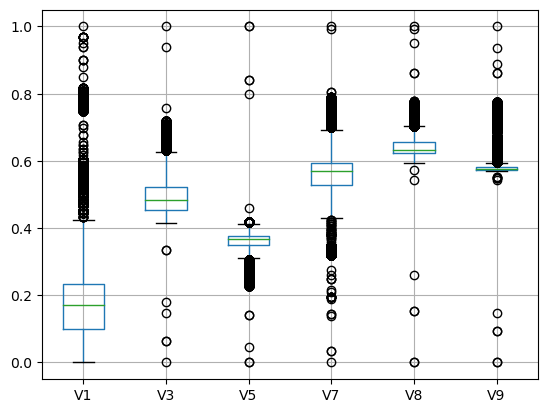

In [10]:
#Checking that scaled values have retained outliers.
df_scaled.boxplot(column=['V1','V3','V5','V7','V8','V9'])
plt.show()

In [11]:
# Assign the features and labels
X = df_scaled.iloc[:, :-1]  # select all rows and all columns except the last one
y = df_scaled.iloc[:, -1]   # select all rows and the last column

# Split the data y values stored for analysis after training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Task 2: model generation and training**


## **Notes**
**Model**<br>
Below the Autoencoder has 7 layers for the encoder and 7 for the decoder. They<br> arent sysmmetrical, no gain found in using sysmetrical models.<br>
A mixture of dense and dropout layers.
<br>
<br>
**Dense layers** were used as the data was Tabular rather than spatial <br>(Conv are ideal for spatial)<br>
<br>
**Relu** was used throughout the model bar the last layer in the decoder. Relu <br>reduces the dimensionality of the input data to a latent space of 2, and <br>helps the encoder learn a compressed representation of the data by setting<br> negative values to 0.
<br>
<br>
To reconstruct the input data a **linear activation** function was used in the <br>final layer of the decoder. The input data had a wide range of values and a <br> linear activation allows for this.<br> <br>


**Prevent local minimas and overfitting**
<br>
**The dropout layer** prevented the model overfitting and falling into local <br>minimas which the model was previously plagued by for certain random datasets. <br> <br>
**Kernel initilizer** He_normal helps break sysmmetry and start the model in a <br>good loss region. This made the model more robust to the randomness of the <br> data split. Getting a recall, precision and f1 score for the anomalies <br>between .8 to .96 while previously it could drop to .3.
<br>

In [12]:
# Define the Encoder
encoder_input = Input(shape=(X_train.shape[1],))  

x = Dense(32, activation='relu',kernel_initializer='he_normal')(encoder_input)
x = Dropout(.2)(x)
x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(.2)(x)
x = Dense(8, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(.2)(x)
latent = Dense(2,activation='relu', kernel_initializer='he_normal')(x)

encoded = Model(encoder_input,latent,name='encoded')
encoded.summary()

# This is the decoder
x = Dense(32,activation='relu',kernel_initializer='he_normal')(latent)
x = Dropout(.2)(x)
x = Dense(32,activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(.2)(x)
x = Dense(16,activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(.2)(x)
rec = Dense(9,activation='linear',kernel_initializer='he_normal')(x)

decoded = Model(latent,rec,name='decoded')
decoded.summary()

decoder_output = decoded(encoded(encoder_input))
#Autoencoder Model
autoencoder = Model(encoder_input,decoder_output)
#Reconstruction loss using Mean squared error of input and decoded output
reconstruction_loss = tf.keras.losses.MeanSquaredError()(encoder_input, decoder_output)
autoencoder.add_loss(reconstruction_loss)
autoencoder.compile(optimizer='adam')
autoencoder.summary()

Model: "encoded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 32)                320       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0   

In [13]:
#early stop function
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model, this can take some time
history = autoencoder.fit(X_train, X_train,
                epochs=400,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping])

#Array of loss values
loss_values = history.history['loss']

Epoch 1/400
307/307 [==============================] - 2s 4ms/step - loss: 0.0508 - val_loss: 0.0043
Epoch 2/400
307/307 [==============================] - 1s 3ms/step - loss: 0.0118 - val_loss: 0.0041
Epoch 3/400
307/307 [==============================] - 1s 3ms/step - loss: 0.0087 - val_loss: 0.0039
Epoch 4/400
307/307 [==============================] - 1s 3ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 5/400
307/307 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 6/400
307/307 [==============================] - 1s 3ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 7/400
307/307 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 8/400
307/307 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 9/400
307/307 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 10/400
307/307 [==============================] - 1s 3ms/step - loss: 0.0039 - val_lo

**Task 3: anomaly detection**

In [14]:
def show_predictions( Model, X, y , Anom_rate = .07):
  '''
  Description: Calculates MSE of the predicted and true values given.
              Calculates the threshold using the MSE and given anomaly rate.
              The cutoff loss for anomalies is plotted with the
              calculated MSE losses.
              Finally the predicted anomaly values are returned.

  '''
  # calculate predictions from our AutoEncoder model for the training dataset
  predictions = Model.predict(X)
  # calculate the mean squared error for each sample
  mse = ((X - predictions) ** 2).mean(axis=1)
  # sort the mse in descending order
  mse_sorted = sorted(mse, reverse=True)
  # calculate the index of the threshold value
  threshold_index = int(len(mse_sorted) * 0.07)

  # set the threshold to the value at the threshold index
  threshold = mse_sorted[threshold_index]
  plt.figure(figsize=(16,8)) 
  y_height, bins, patches = plt.hist(mse, bins=100)
  # add a vertical line to the plot at the threshold value
  plt.vlines(threshold, 0, y_height.max(), color="orange", linewidth=2)
  plt.show()
  # identify the samples that have a mse greater than the threshold
  y_results =  pd.DataFrame([1 if x > threshold else 0 for x in mse])
  anomalies = X[mse > threshold]
  accuracy = np.round(abs(len(anomalies)/sum(y ==1)),2)

  print(f'Cutoff threshold is {threshold}' +
        f' \n Number of anomolies predicted {len(anomalies)}, actual {sum(y==1)}'+
        f'\n Accuracy of predicted amount {accuracy}%' )
  return y_results

In [15]:
def con_matrix (y_true,y_pred):
  '''
  Description: Calculates the confusion matrix values.
               Seperates these values and plots them with the predicted
               percentage for each quadrant.
               The classification report prints the metrics of the model.
  ''' 

  # calculating True Neg, False Pos, False Neg, True Pos
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(16,8)) 
  #seperating values
  TN, FP, FN, TP = cm.flatten()
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = [ TN, FP, FN, TP]
  # Calculating the percentages of each quadrant
  group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
  # Array of quardants' information
  labels = [f'{v1}\n{v2}\n{v3} 'for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  #plotting heat map.
  sns.heatmap(cm, annot=labels, fmt='')
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()
  print(classification_report(y_true, y_pred))

### Test using Training set


1228/1228 [==============================] - 2s 1ms/step


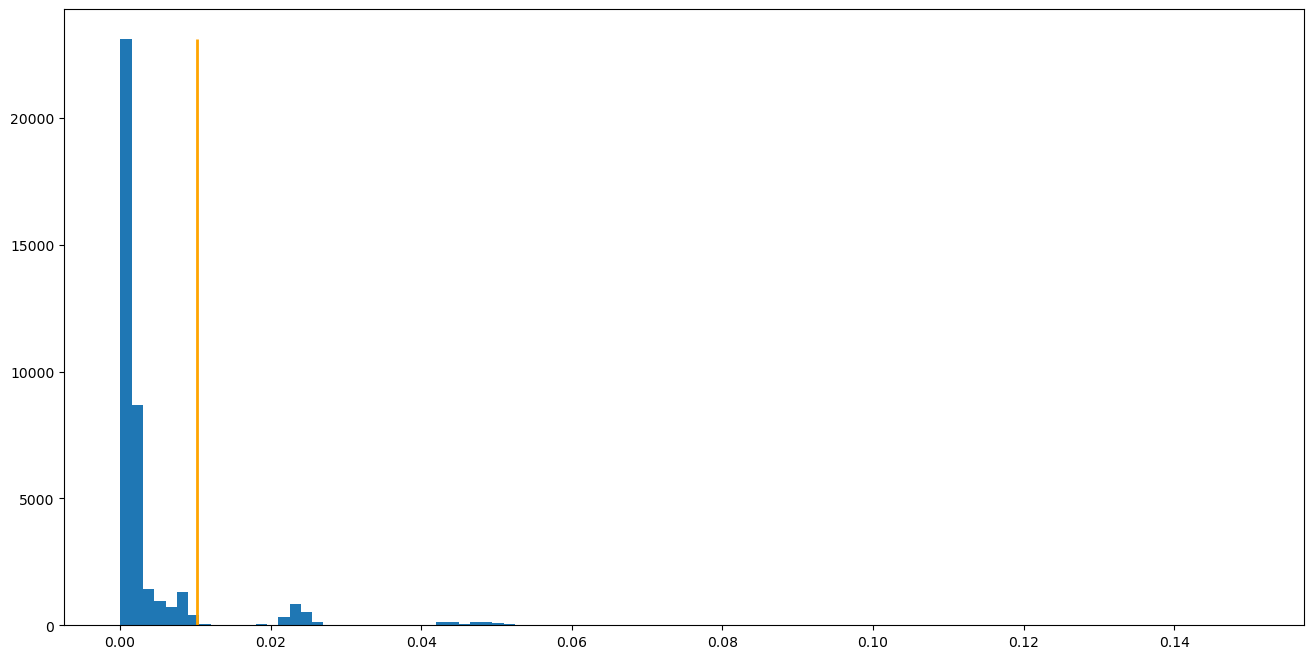

Cutoff threshold is 0.010221872574317023 
 Number of anomolies predicted 2749, actual 2791
 Accuracy of predicted amount 0.98%


In [16]:
y_results = show_predictions(autoencoder,X_train,y_train,.07)

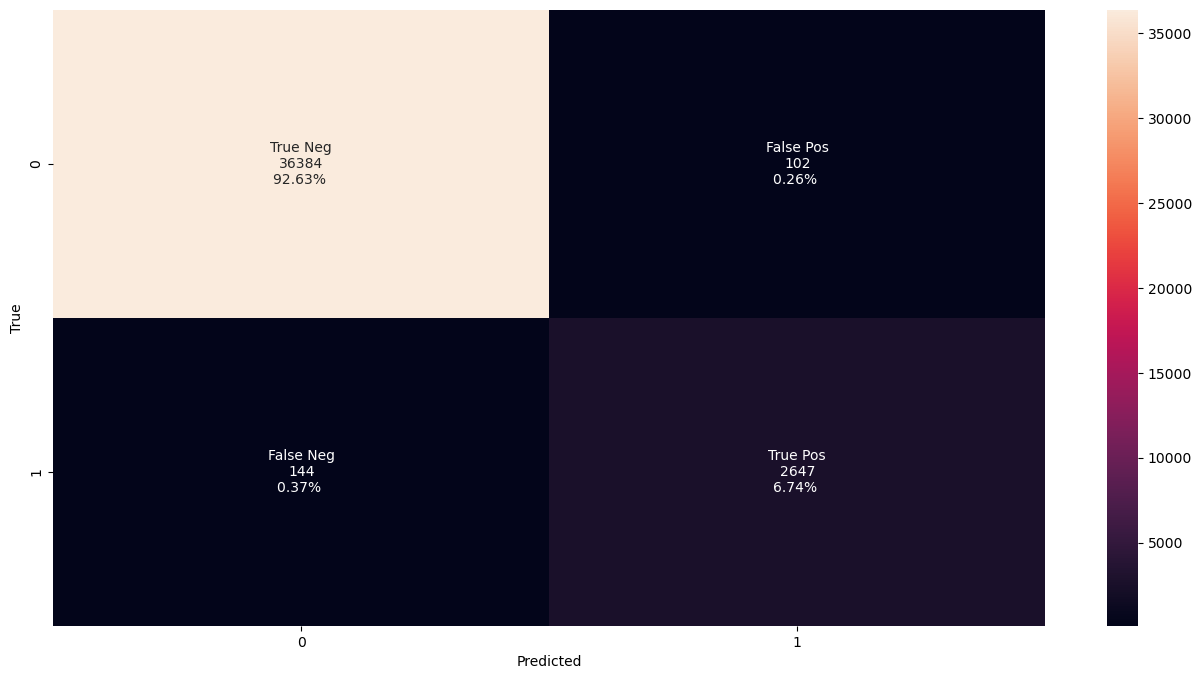

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     36486
         1.0       0.96      0.95      0.96      2791

    accuracy                           0.99     39277
   macro avg       0.98      0.97      0.98     39277
weighted avg       0.99      0.99      0.99     39277



In [17]:
con_matrix(y_train,y_results)

#### Using Test dataset

307/307 [==============================] - 1s 2ms/step


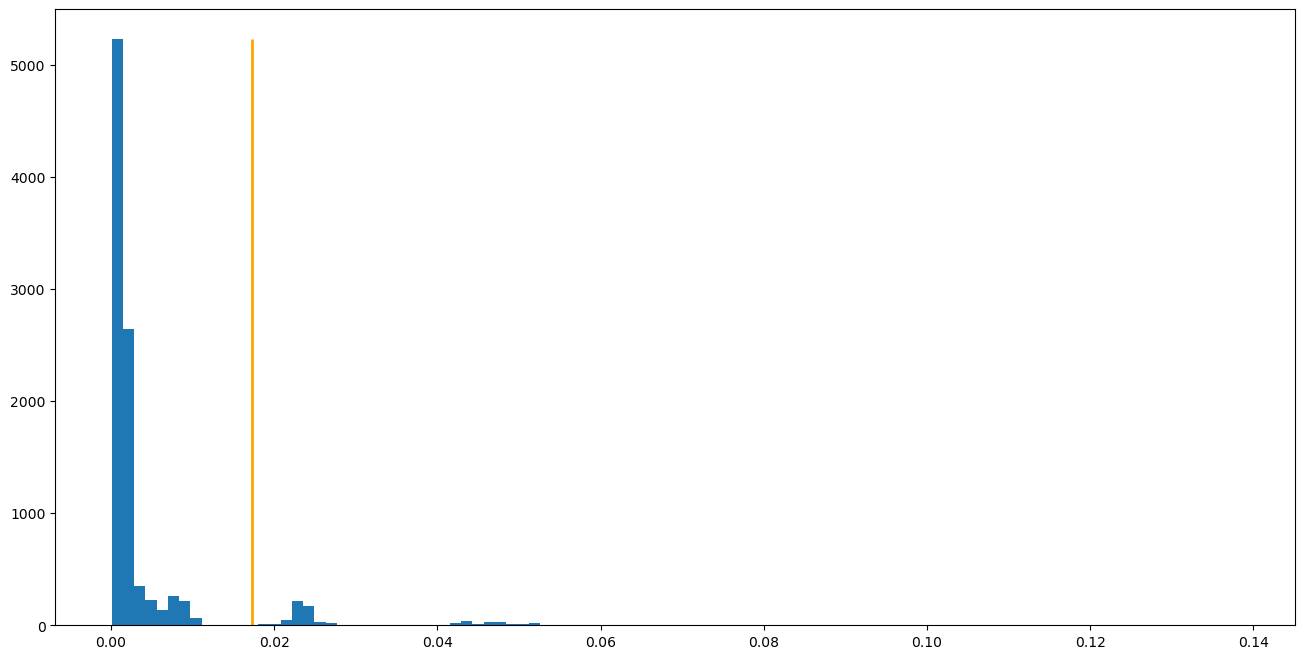

Cutoff threshold is 0.017276280646298985 
 Number of anomolies predicted 687, actual 720
 Accuracy of predicted amount 0.95%


In [18]:
y_results = show_predictions(autoencoder,X_test,y_test,.07)

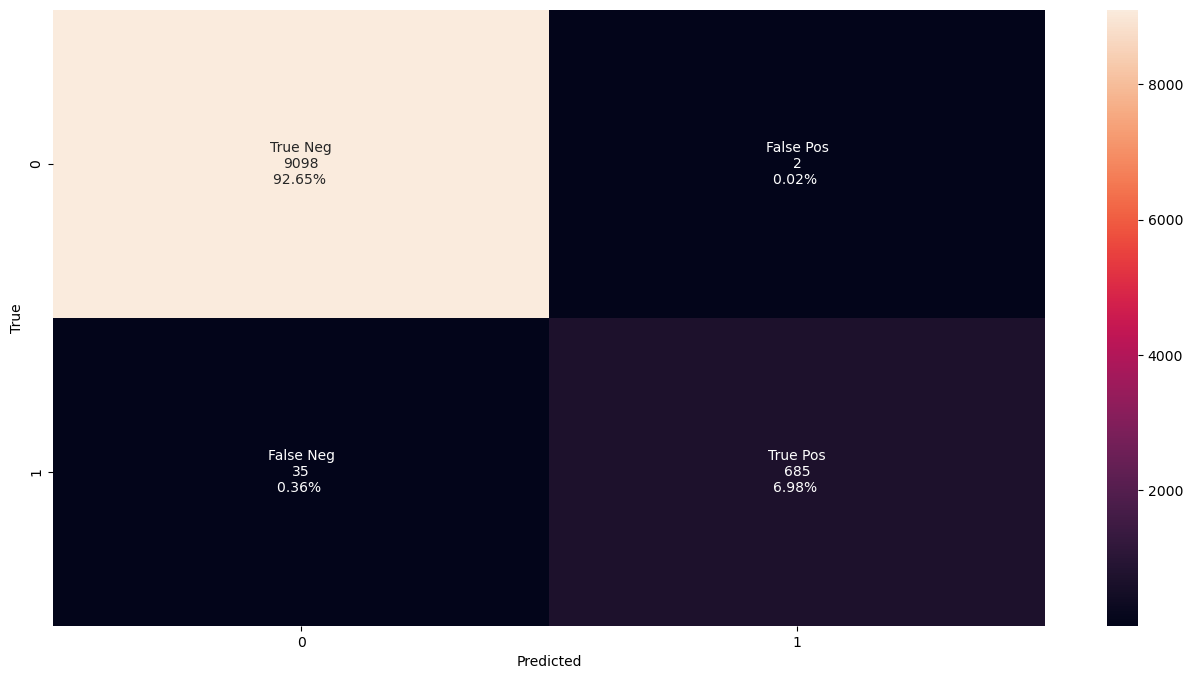

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9100
         1.0       1.00      0.95      0.97       720

    accuracy                           1.00      9820
   macro avg       1.00      0.98      0.99      9820
weighted avg       1.00      1.00      1.00      9820



In [19]:
con_matrix(y_test,y_results)

### Task 4: VAE
Changed the network to be a VAE. 

In [20]:
def sampling(args):
    '''
    Description: Using the inputted mean and log var, a random variable is
    stored as epsilon.
    The random variable is then used in conjuntion with the given mean and
    log var to calculate the reparmeterization trick.
    
    '''
    #Getting mean and log var from inputs
    z_mean, z_log_var = args
    #Calculating random variable from normal distribution
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    #returning the reparmetrization trick
    return z_mean + K.exp(z_log_var) * epsilon

## **Notes**
**Model**
The VAE has the same architecture of the AE. <br>
It performs similar to the AE also.<br>
The reparmeterization trick is the only additional layer.
<br>
<br>
**Reparmeterization trick** <br>
The reparmeterization trick provides the latent space with noise via the <br>selected random variable. This random variable is selected over a <br>normal distribution given the calculated mean and log var. This prevents <br>deterministic mapping, i.e. the same inputs generate the same outputs. By <br>incorparating noise into the equation the model can produce an output with <br>some variation. <br>
This leads to a more generalized model.

In [21]:
# Define the Encoder
latent_dim= 2
encoder_input = Input(shape=(X_train.shape[1],))  

x = Dense(32, activation='relu', kernel_initializer='he_normal')(encoder_input)
x = Dropout(.2)(x)
x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(.2)(x)
x = Dense(8, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(.2)(x)
latent = Dense(latent_dim,activation='relu', kernel_initializer='he_normal')(x)

# reparameterization trick
z_mean = Dense(latent_dim)(latent)
z_log_var = Dense(latent_dim)(latent)
#Latent representation
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoded.summary()

# This is the decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(32,activation='relu', kernel_initializer='he_normal')(latent_inputs)
x = Dropout(.2)(x)
x = Dense(32,activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(.2)(x)
x = Dense(16,activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(.2)(x)
rec = Dense(9,activation='linear', kernel_initializer='he_normal')(x)

decoded = Model(latent_inputs,rec,name='decoded')
decoded.summary()

decoder_output = decoded(encoded(encoder_input))
#Autoencoder Model
vae = Model(encoder_input,decoder_output)
vae.summary()

Model: "encoded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 32)                320       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0   

In [22]:
#Reconstruction loss calculated using mse
vae_reconstruction_loss = mse(encoder_input,decoder_output)
vae_reconstruction_loss *= 9
#Calculating the KL loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
# Adding vae loss, the mean of the reconstruction + KL loss
vae_loss = K.mean(vae_reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [23]:
#Early stop
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# train the autoencoder
vae.compile(optimizer= Adam(learning_rate=0.001))
vae.fit(X_train, X_train,
                epochs=400,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping])

Epoch 1/400
307/307 [==============================] - 3s 4ms/step - loss: 1.4298 - val_loss: 0.6793
Epoch 2/400
307/307 [==============================] - 1s 3ms/step - loss: 0.1338 - val_loss: 0.0347
Epoch 3/400
307/307 [==============================] - 1s 4ms/step - loss: 0.0485 - val_loss: 0.0343
Epoch 4/400
307/307 [==============================] - 1s 4ms/step - loss: 0.0448 - val_loss: 0.0338
Epoch 5/400
307/307 [==============================] - 1s 4ms/step - loss: 0.0429 - val_loss: 0.0340
Epoch 6/400
307/307 [==============================] - 1s 4ms/step - loss: 0.0412 - val_loss: 0.0340
Epoch 7/400
307/307 [==============================] - 1s 4ms/step - loss: 0.0401 - val_loss: 0.0338
Epoch 8/400
307/307 [==============================] - 1s 4ms/step - loss: 0.0389 - val_loss: 0.0337
Epoch 9/400
307/307 [==============================] - 1s 4ms/step - loss: 0.0380 - val_loss: 0.0337
Epoch 10/400
307/307 [==============================] - 1s 4ms/step - loss: 0.0371 - val_lo

### Predictions using train dataset

1228/1228 [==============================] - 2s 2ms/step


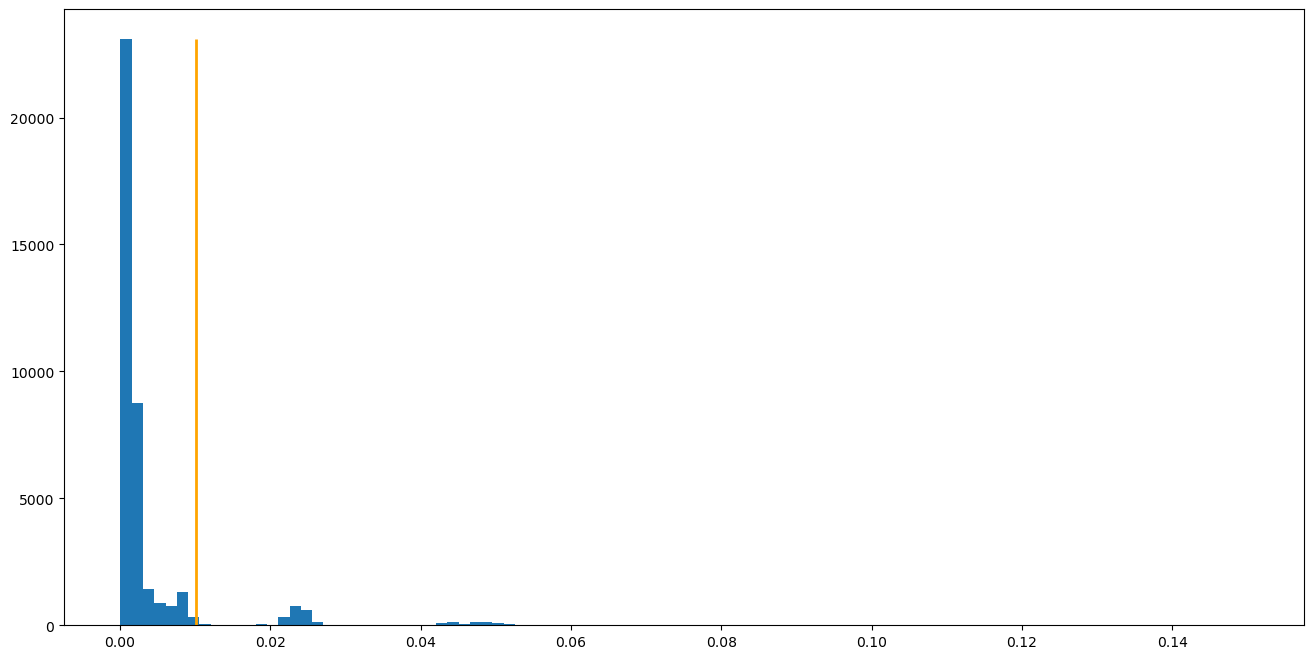

Cutoff threshold is 0.010104867054898182 
 Number of anomolies predicted 2749, actual 2791
 Accuracy of predicted amount 0.98%


In [24]:
y_results = show_predictions(vae,X_train,y_train,.07)

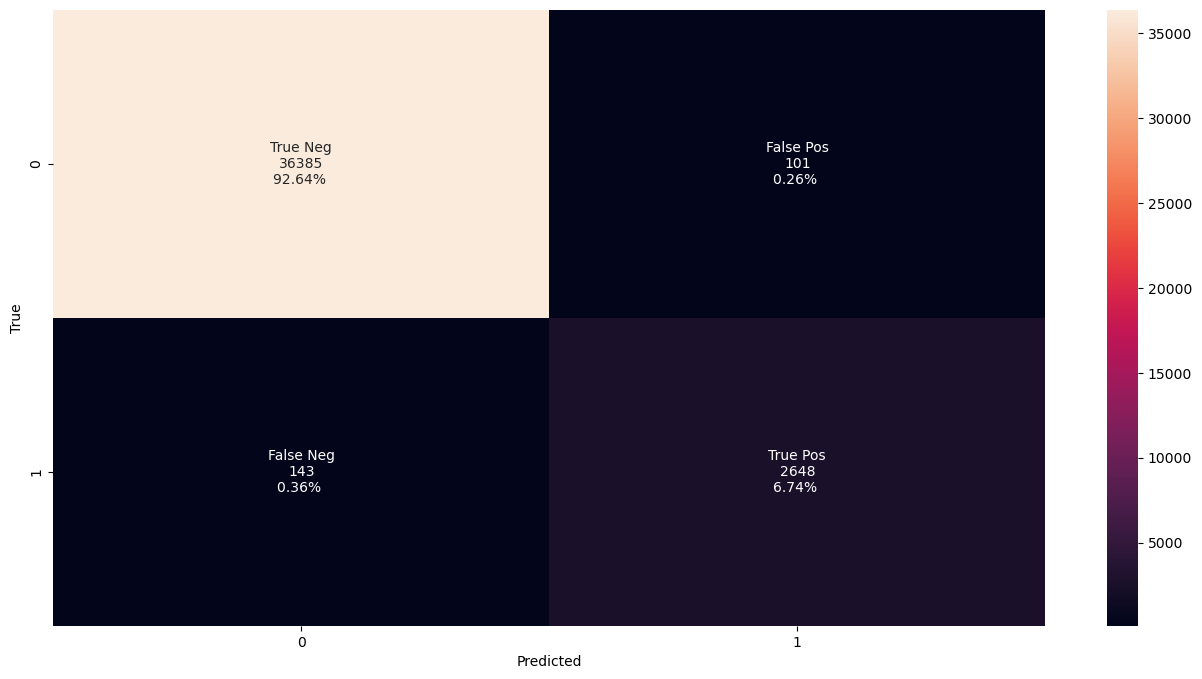

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     36486
         1.0       0.96      0.95      0.96      2791

    accuracy                           0.99     39277
   macro avg       0.98      0.97      0.98     39277
weighted avg       0.99      0.99      0.99     39277



In [25]:
con_matrix(y_train,y_results)

307/307 [==============================] - 0s 1ms/step


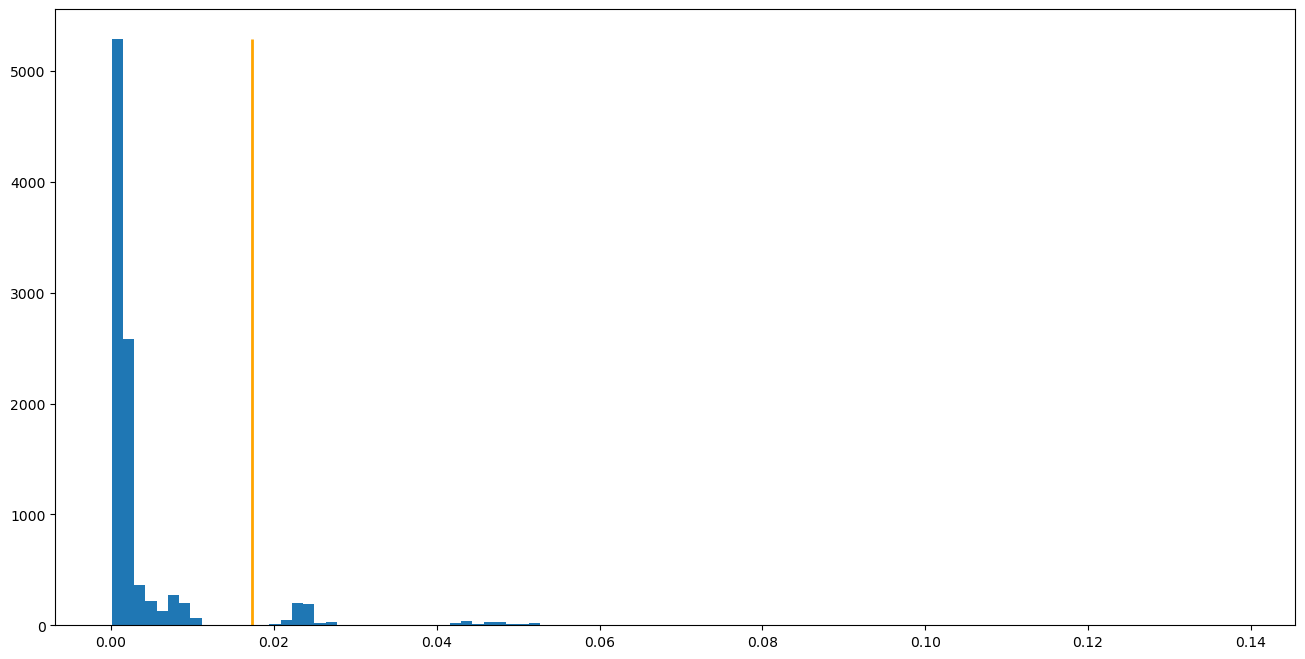

Cutoff threshold is 0.017344286555293142 
 Number of anomolies predicted 687, actual 720
 Accuracy of predicted amount 0.95%


In [26]:
y_results = show_predictions(vae,X_test,y_test,.07)

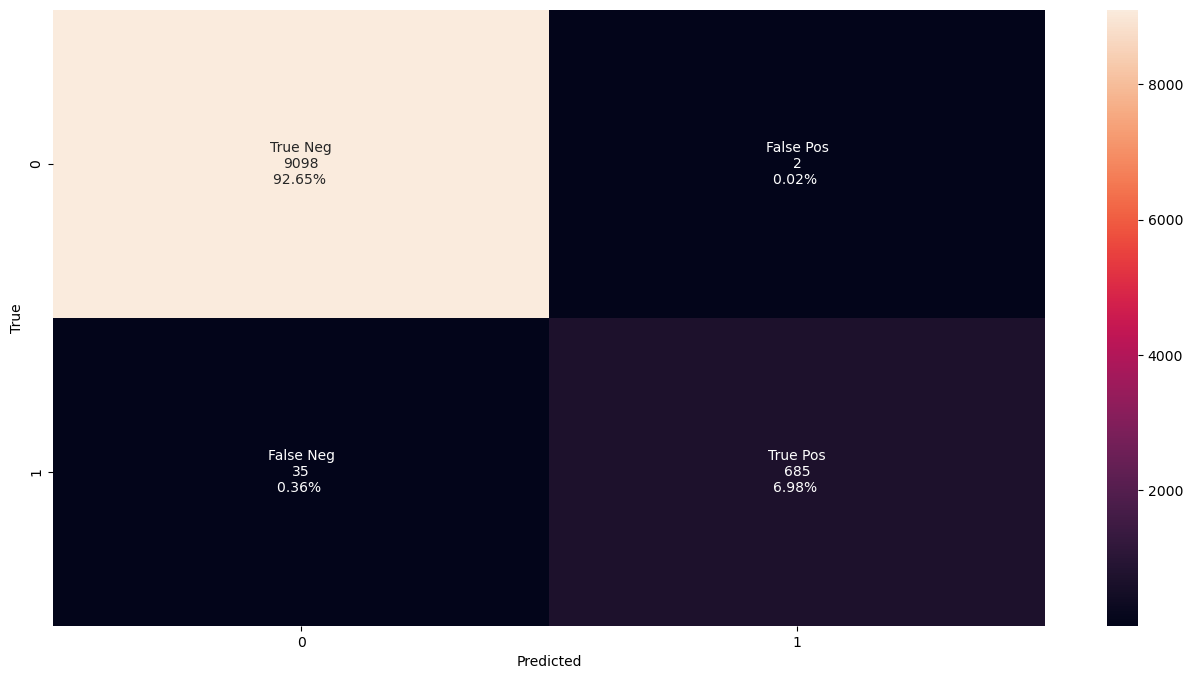

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9100
         1.0       1.00      0.95      0.97       720

    accuracy                           1.00      9820
   macro avg       1.00      0.98      0.99      9820
weighted avg       1.00      1.00      1.00      9820



In [27]:
con_matrix(y_test,y_results)

## Conclusion
The accuracy was misleading for the AE and VAE.<br>
When using the classification report, the performance of the models was <br>revealed.<br>
The finalized models both have the same architecture. With approximately 2900 <br>params. This provided robust models, which is needed with a random data <br>set. Sometimes the precision, recall and f1 score can reach as low as .79 <br>and up to .96 depending on the data split. 
<br>
<br>
When the layers were increased to approx. 5000 the model didn't perform better <br>and in some cases worse. It was noted that the VAE was more sensitive to <br>the increase and performed poorly while the AE performed similar to the <br>optimal model.
<br>
<br>
Less layers did perform just as well as the current model, but when the data <br>split unfavourably the lessening layers saw a drop to as low as .06  on the anonalies for precision, recall, and f1 score.
<br>
<br>
Therefore around the 3,000 params mark with precautions taken for overfitting <br>and local minimas in terms of kernel optimizers and dropout layers seemed <br>to give the best overall model.
<br>
<br>
**Comparison**<br>
The AE generally outperformed the VAE which is uncommon as VAE's use the <br>reparmeterization to improve generalization. This happened when the layers <br>were adjusted (increased and decreased) and unfavourable data splits <br> occured. Reasoning from this outcome and the model architecture, the small <br>latent space might be the cause of this, with a dimension of 2. Another <br>possibilty is that the VAE is suffering from a irregular latent space while <br>AE is better able to combat this, but this is less likely given the data has only 9 inputs.

